In [73]:
from utilities import get_ohlc_data
import pandas as pd

In [74]:

tickers = ['MSFT']
adjusted_close = get_ohlc_data(tickers, start_date='2016-01-01')



[*********************100%%**********************]  1 of 1 completed


In [75]:
data_msft = pd.DataFrame(adjusted_close['MSFT'])
data_msft.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,54.320000,54.799999,53.389999,54.799999,48.608986,53778000
2016-01-05,54.930000,55.389999,54.540001,55.049999,48.830746,34079700
2016-01-06,54.320000,54.400002,53.639999,54.049999,47.943718,39518900
2016-01-07,52.700001,53.490002,52.070000,52.169998,46.276123,56564900
2016-01-08,52.369999,53.279999,52.150002,52.330002,46.418045,48754000


In [82]:
import numpy as np
data_msft["Ret1"] = data_msft['Adj Close'].pct_change()
data_msft["Ret120"] = data_msft['Ret1'].rolling(120).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
data_msft["Buy"] = data_msft["Ret120"] > 0

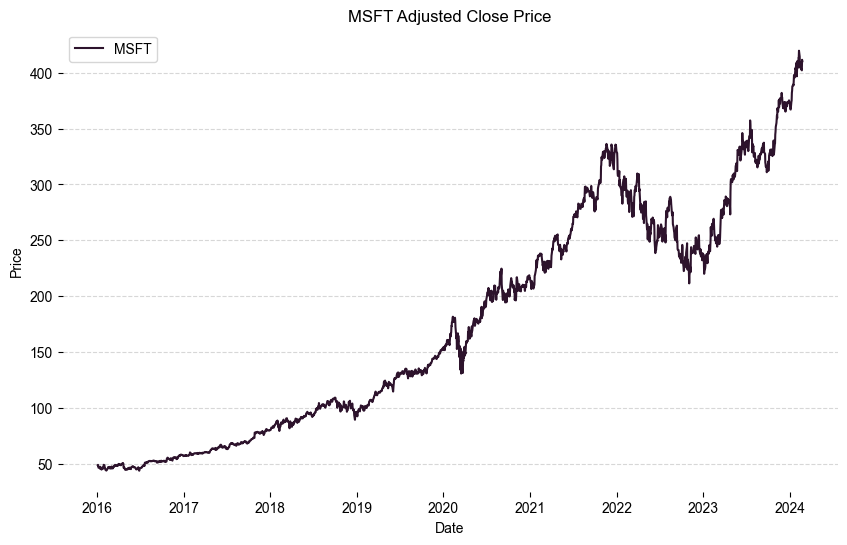

In [77]:
from visualisation import plot_smooth_multiline_chart, plot_acf_pacf_side_by_side
plot_smooth_multiline_chart(data=[(data_msft['Adj Close'].index,data_msft['Adj Close'], 'MSFT')], title='MSFT Adjusted Close Price', x_label='Date',y_label='Price').show()

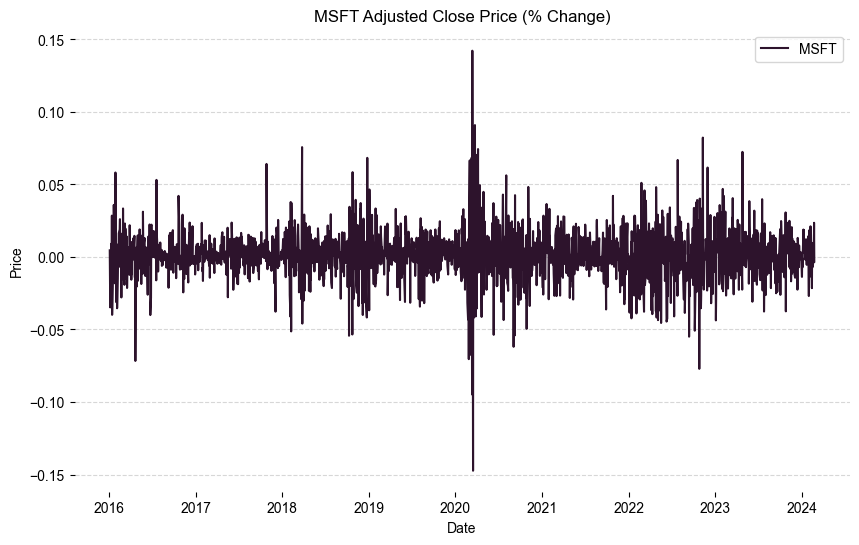

In [78]:
plot_smooth_multiline_chart(data=[(data_msft['Adj Close'].index,data_msft['Adj Close'].pct_change(), 'MSFT')], title='MSFT Adjusted Close Price (% Change)', x_label='Date', y_label='Price').show()

C:\Users\kumar\AppData\Local\Temp\ipykernel_25616\4170750782.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_acf_pacf_side_by_side(data_msft['Adj Close'], lags=50, title='ACF and PACF (MSFT Prices)').show()


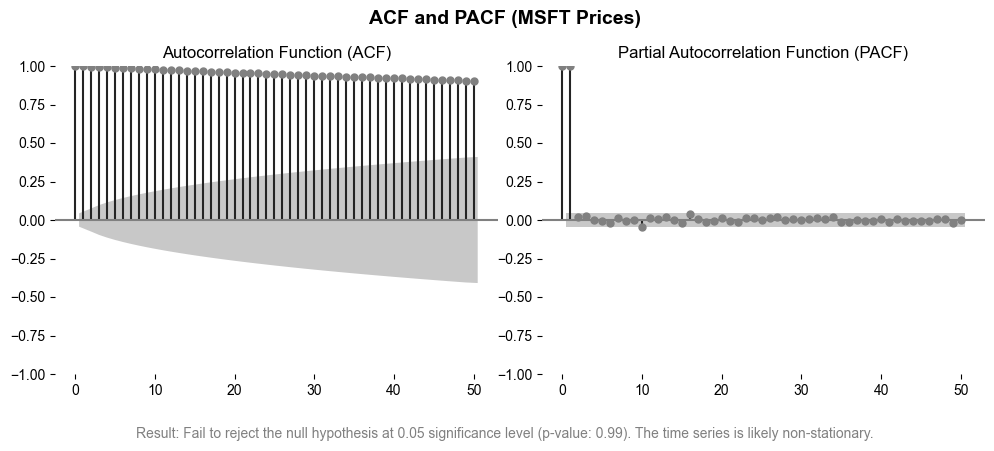

In [79]:
plot_acf_pacf_side_by_side(data_msft['Adj Close'], lags=50, title='ACF and PACF (MSFT Prices)').show()

C:\Users\kumar\AppData\Local\Temp\ipykernel_25616\2364156421.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_acf_pacf_side_by_side(data_msft['Adj Close'].pct_change()[1:], lags=50, title='ACF and PACF (MSFT Price % Change)').show()


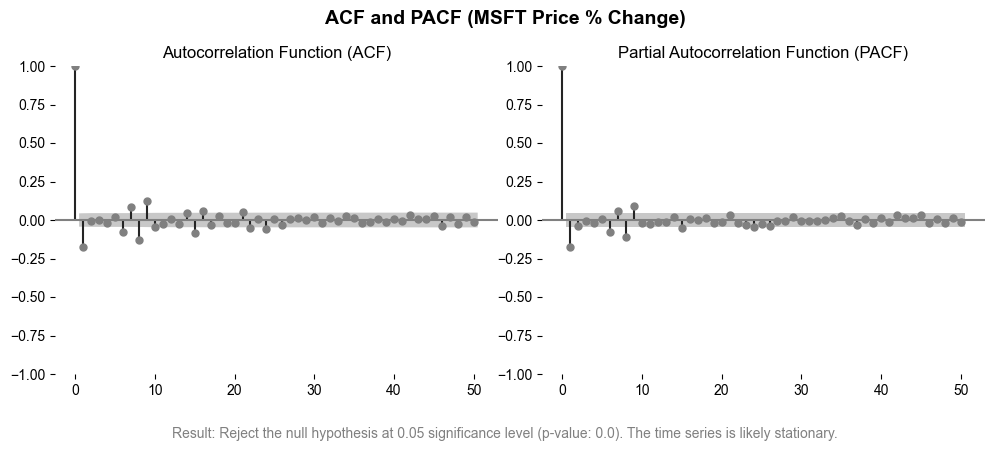

In [80]:
plot_acf_pacf_side_by_side(data_msft['Adj Close'].pct_change()[1:], lags=50, title='ACF and PACF (MSFT Price % Change)').show()

In [83]:
from technical_indicators import calculate_bollinger_bands, calculate_adx, calculate_rsi
from itertools import product
for func, window in product([calculate_bollinger_bands,calculate_rsi,calculate_adx], [20,30,50]):
    series = func(data_msft, window)
    data_msft[series.name] = series
data_msft.dropna(inplace=True)
data_msft.drop(['Ret1', 'Ret120', 'Open', 'High', 'Low', 'Close', 'Adj Close'], axis=1, inplace=True)

In [85]:
from preprocessing import encode_labels, train_test_split
DATA = encode_labels(data_msft, ['Buy'])
DATA = encode_labels(data_msft, [column for column in data_msft.columns if column.startswith('Bollinger')])
DATA = train_test_split(DATA, test_size=0.2)

In [87]:
import tensorflow as tf

tf.keras.backend.clear_session()  # We clear the backend to reset the random seed process
tf.random.set_seed(
    1234
)  # We will set a random seed so that results obtained are somewhat replicable

act_fun = "relu"
hp_units = 25
hp_units_2 = 15
hp_units_3 = 10
n_dropout = 0.2

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=hp_units, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

hp_lr = 1e-5  # Learning rate

adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer

model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

In [25]:
calculate_adx(data_msft)

,Open,High,Low,Close,Adj Close,Volume,RSI,ADX
Date,,,,,,,,
2020-01-02,158.779999,160.729996,158.330002,160.619995,154.493835,22622100,NaN,NaN
2020-01-03,158.320007,159.949997,158.059998,158.619995,152.570114,21116200,NaN,NaN
2020-01-06,157.080002,159.100006,156.509995,159.029999,152.964462,20813700,NaN,NaN
2020-01-07,159.320007,159.669998,157.320007,157.580002,151.569809,21634100,NaN,NaN
2020-01-08,158.929993,160.800003,157.949997,160.089996,153.984055,27746500,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-02-16,407.959991,408.290009,403.440002,404.059998,404.059998,22281100,46.499233,52.979875
2024-02-20,403.239990,404.489990,398.010010,402.790009,402.790009,24307900,46.405088,47.742012
2024-02-21,400.170013,402.290009,397.220001,402.179993,402.179993,18631100,54.459738,44.689148
